# CH3. 비지도 그래프 학습(오토인코더)

김보람  
2023-04-06

# ref

-   [그래프
    머신러닝](https://product.kyobobook.co.kr/detail/S000200738068)

-   [github](https://github.com/PacktPublishing/Graph-Machine-Learning)

# 오토인코더(AutoEncoder)

-   입력과 출력이 기본적으로 동일, 은닉충에서 적은 수의 유닛 사용

-   상당히 적은 수의 변수 및 자유도를 사용해 입력을 재구성하도록
    학습하는 신경망

-   입력과 출력의 차이 최소화하여 학습

-   손실함수: 평균 제곱 오차, 평균 절대 오차, 교차 엔트로피, KL발산 등

`-` 구성

-   인코더 네트워크: 하나 이상의 단위를 통해 입력을 처리하고, 입력의
    차원을 줄이고 희소성을 제한하는 인코딩된 표현으로 매핑

-   디코더 네트워크: 중간 계층의 인코딩된 표현에서 입력 신호 재구성

## Load Dataset

In [3]:
import tensorflow as tf
from tensorflow.keras.datasets import fashion_mnist

2023-04-06 18:27:51.222436: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.

In [4]:
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

4422102/4422102 [==============================] - 0s 0us/step

In [6]:
x_train = x_train.astype('float32') / 255. #0~1사이로 정규화 하기 위하여
x_test = x_test.astype('float32') / 255.

print (x_train.shape)
print (x_test.shape)

(60000, 28, 28)
(10000, 28, 28)

In [7]:
from matplotlib import pyplot as plt

In [9]:
classes = {
    0:"T-shirt/top",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle boot", 
}

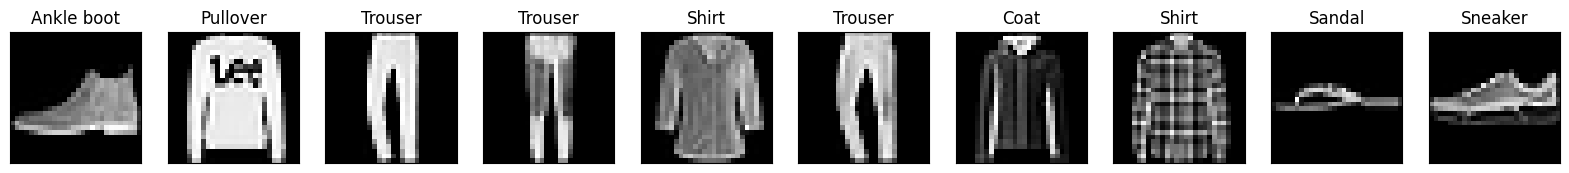

In [10]:
n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(1, n, i + 1)
    plt.imshow(x_test[i])
    plt.title(classes[y_test[i]])
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

plt.show()
# plt.savefig("TrainingSet.png")

## Create Autoencoder

In [11]:
from tensorflow.keras.layers import Flatten, Conv2D, Dropout, MaxPooling2D, UpSampling2D, Input

In [12]:
from tensorflow.keras import Model

### 인코더/디코더

In [14]:
input_img = Input(shape=(28, 28, 1))

#인코딩
x = Conv2D(16, (3, 3), activation='relu', padding='same')(input_img)      # 출력값 28x28x16
x = MaxPooling2D((2, 2), padding='same')(x)                               # 출력값 14x14x16
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)               # 출력값 14x14x8
x = MaxPooling2D((2, 2), padding='same')(x)                               # 출력값 7x7x8
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)               # 출력값 7x7x8
encoded = MaxPooling2D((2, 2), padding='same')(x)                         # 출력값 4x4x8

# at this point the representation is (4, 4, 8) i.e. 128-dimensional

#디코딩
x = Conv2D(8, (3, 3), activation='relu', padding='same')(encoded)         # 출력값 4x4x8
x = UpSampling2D((2, 2))(x)                                               # 출력값 8x8x8
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(16, (3, 3), activation='relu')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

autoencoder = Model(input_img, decoded)

In [15]:
Model(input_img, encoded).summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d_7 (Conv2D)           (None, 28, 28, 16)        160       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 14, 14, 16)       0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (None, 14, 14, 8)         1160      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 7, 7, 8)          0         
 2D)                                                             
                                                                 
 conv2d_9 (Conv2D)           (None, 7, 7, 8)           584 

### 손실함수/옵티마이저

In [16]:
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

### 학습

In [17]:
from tensorflow.keras.callbacks import TensorBoard

In [18]:
autoencoder.fit(x_train, x_train,
                epochs=50,
                batch_size=128,
                shuffle=True,
                validation_data=(x_test, x_test),
                callbacks=[TensorBoard(log_dir='/tmp/autoencoder')])

Epoch 1/50
469/469 [==============================] - 11s 23ms/step - loss: 0.0399 - val_loss: 0.0086
Epoch 2/50
469/469 [==============================] - 11s 23ms/step - loss: 0.0085 - val_loss: 0.0085
Epoch 3/50
469/469 [==============================] - 11s 23ms/step - loss: 0.0085 - val_loss: 0.0085
Epoch 4/50
469/469 [==============================] - 11s 23ms/step - loss: 0.0084 - val_loss: 0.0084
Epoch 5/50
469/469 [==============================] - 11s 23ms/step - loss: 0.0084 - val_loss: 0.0084
Epoch 6/50
469/469 [==============================] - 11s 23ms/step - loss: 0.0084 - val_loss: 0.0083
Epoch 7/50
469/469 [==============================] - 11s 23ms/step - loss: 0.0083 - val_loss: 0.0083
Epoch 8/50
469/469 [==============================] - 11s 23ms/step - loss: 0.0082 - val_loss: 0.0083
Epoch 9/50
469/469 [==============================] - 11s 23ms/step - loss: 0.0082 - val_loss: 0.0082
Epoch 10/50
469/469 [==============================] - 11s 23ms/step - loss: 0.008

In [19]:
autoencoder.save("./data/Batch50.p")

INFO:tensorflow:Assets written to: ./data/Batch50.p/assets

INFO:tensorflow:Assets written to: ./data/Batch50.p/assets

### 예측

#### 예시1

In [20]:

from tensorflow.keras.models import load_model

In [21]:
autoencoder_first = load_model("./data/Batch50.p")

313/313 [==============================] - 0s 1ms/step

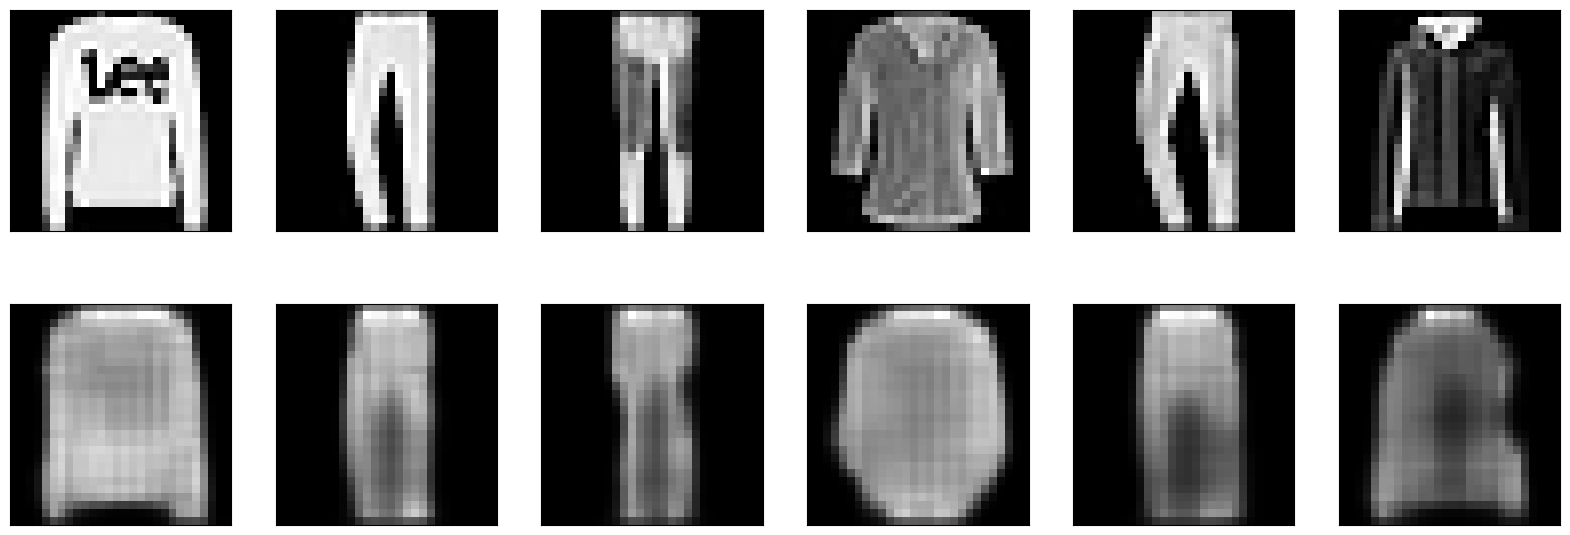

In [23]:
decoded_imgs = autoencoder_first.predict(x_test)

n = 6
plt.figure(figsize=(20, 7))
for i in range(1, n + 1):
    # Display original
    ax = plt.subplot(2, n, i)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display reconstruction
    ax = plt.subplot(2, n, i + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)  #X축 숨기기
    ax.get_yaxis().set_visible(False)
plt.show()

-   첫 줄 우너본 이미지, 두번째 줄 재구성된 이미지

#### 예시2

In [25]:
from tensorflow.keras.optimizers import Adam

In [27]:
autoencoder.compile(optimizer=Adam(learning_rate=0.0005), loss='binary_crossentropy')

In [29]:
autoencoder.fit(x_train, x_train,
                epochs=10,
                batch_size=128,
                shuffle=True,
                validation_data=(x_test, x_test),
                callbacks=[TensorBoard(log_dir='/tmp/autoencoder')])

Epoch 1/10
469/469 [==============================] - 11s 23ms/step - loss: 0.0079 - val_loss: 0.0079
Epoch 2/10
469/469 [==============================] - 11s 23ms/step - loss: 0.0079 - val_loss: 0.0079
Epoch 3/10
469/469 [==============================] - 11s 23ms/step - loss: 0.0079 - val_loss: 0.0080
Epoch 4/10
469/469 [==============================] - 11s 23ms/step - loss: 0.0079 - val_loss: 0.0079
Epoch 5/10
469/469 [==============================] - 11s 23ms/step - loss: 0.0079 - val_loss: 0.0079
Epoch 6/10
469/469 [==============================] - 11s 23ms/step - loss: 0.0079 - val_loss: 0.0079
Epoch 7/10
469/469 [==============================] - 11s 23ms/step - loss: 0.0079 - val_loss: 0.0079
Epoch 8/10
469/469 [==============================] - 11s 23ms/step - loss: 0.0079 - val_loss: 0.0079
Epoch 9/10
469/469 [==============================] - 11s 23ms/step - loss: 0.0079 - val_loss: 0.0079
Epoch 10/10
469/469 [==============================] - 11s 23ms/step - loss: 0.007

epochs 위에건 50.. 넘 오래걸려서 10개로 줄여보자

In [30]:
autoencoder.save("./data/Batch100.p")

INFO:tensorflow:Assets written to: ./data/Batch100.p/assets

INFO:tensorflow:Assets written to: ./data/Batch100.p/assets

313/313 [==============================] - 1s 2ms/step

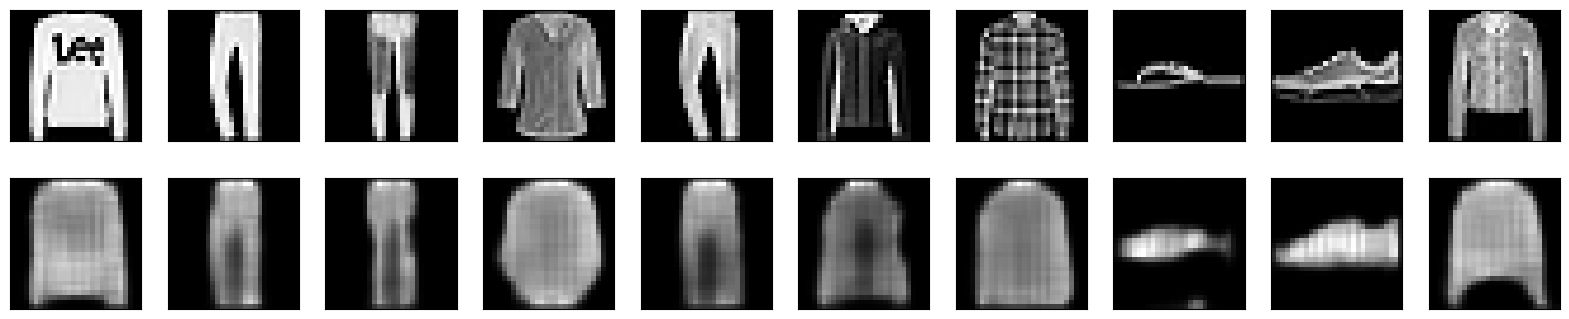

In [31]:
decoded_imgs = autoencoder.predict(x_test)

n = 10
plt.figure(figsize=(20, 4))
for i in range(1, n + 1):
    # Display original
    ax = plt.subplot(2, n, i)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display reconstruction
    ax = plt.subplot(2, n, i + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

plt.show()

아담으로 5번 한거랑 우에서 50번한거랑 비슷하게 나왔땅

## Embeddings(T-SNE사용)

`-` T-SNE: 2차원 평면에서 이미지 인코딩된 버전 표현

In [32]:
embeddings = Model(input_img, Flatten()(encoded)).predict(x_test)

313/313 [==============================] - 0s 815us/step

In [33]:
from sklearn.manifold import TSNE
import numpy as np

In [34]:
tsne = TSNE(n_components=2)

In [35]:
emb2d = tsne.fit_transform(embeddings)

In [36]:
x,y = np.squeeze(emb2d[:, 0]), np.squeeze(emb2d[:, 1])

-   `np.squeeze(emb2d[:, 0])`는 emb2d의 모든 행에서 첫 번째 열만
    선택하여 1차원 배열로 만드는 함수. 이를 통해 2차원 배열의 차원을
    축소시키고, x좌표 값을 얻을 수 있다.

-   `np.squeeze(emb2d[:, 1])`는 emb2d의 모든 행에서 두 번째 열만
    선택하여 1차원 배열로 만드는 함수. 이를 통해 2차원 배열의 차원을
    축소시키고, y좌표 값을 얻을 수 있다.

In [37]:
import pandas as pd

In [38]:
from matplotlib.cm import tab10

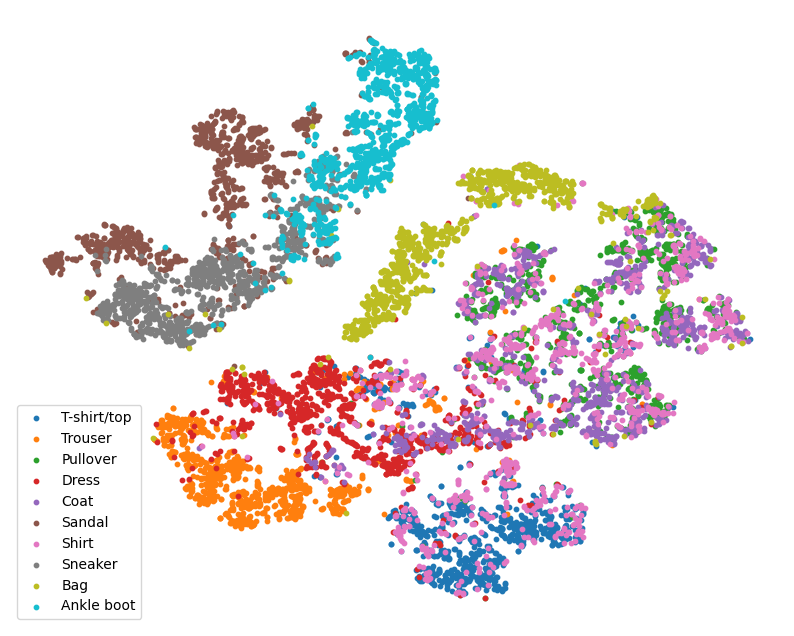

In [39]:
summary =  pd.DataFrame({"x": x, "y": y, "target": y_test, "size": 10})

plt.figure(figsize=(10,8))

for key, sel in summary.groupby("target"):
    plt.scatter(sel["x"], sel["y"], s=10, color=tab10.colors[key], label=classes[key])
    
plt.legend()
plt.axis("off")

-   샘플이 속한 클래스에 따라서 색상이 지정

-   서로 다른 의류의 클러스터링 명확

> 단점: 학습된 이미지를 정확히 재생성하고 일반화하지 않는 경향

## Denoising

`-` 노이즈 제거 오토인코더 : 다양한 강도의 노이즈를 사용해 손상된 입력에
대해 노이즈 없는 답안 사용

In [40]:
from tensorflow.keras.layers import GaussianNoise

In [41]:
input_img = Input(shape=(28, 28, 1))

noisy_input = GaussianNoise(0.1)(input_img)

x = Conv2D(16, (3, 3), activation='relu', padding='same')(noisy_input)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)

# at this point the representation is (4, 4, 8) i.e. 128-dimensional

x = Conv2D(8, (3, 3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(16, (3, 3), activation='relu')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

noisy_autoencoder = Model(input_img, decoded)

-   손상된 입력을 사용해 네트워크 훈련

-   출력에는 노이즈 없는 이미지 사용

-   `GaussianNoise` 학습 중에 확률적 노이즈 추가

In [42]:
Model(input_img, decoded).summary()

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 gaussian_noise (GaussianNoi  (None, 28, 28, 1)        0         
 se)                                                             
                                                                 
 conv2d_14 (Conv2D)          (None, 28, 28, 16)        160       
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 14, 14, 16)       0         
 2D)                                                             
                                                                 
 conv2d_15 (Conv2D)          (None, 14, 14, 8)         1160      
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 7, 7, 8)          0   

In [43]:
noisy_autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

In [50]:
noisy_autoencoder.fit(x_train, x_train,
                epochs=50,
                batch_size=128,
                shuffle=True,
                validation_data=(x_test, x_test),
                callbacks=[TensorBoard(log_dir='/tmp/noisy_autoencoder')])

Epoch 1/50
469/469 [==============================] - 11s 23ms/step - loss: 0.0084 - val_loss: 0.0201
Epoch 2/50
469/469 [==============================] - 11s 23ms/step - loss: 0.0084 - val_loss: 0.0193
Epoch 3/50
469/469 [==============================] - 11s 23ms/step - loss: 0.0084 - val_loss: 0.0180
Epoch 4/50
469/469 [==============================] - 11s 23ms/step - loss: 0.0084 - val_loss: 0.0162
Epoch 5/50
469/469 [==============================] - 11s 23ms/step - loss: 0.0084 - val_loss: 0.0157
Epoch 6/50
469/469 [==============================] - 11s 23ms/step - loss: 0.0084 - val_loss: 0.0150
Epoch 7/50
469/469 [==============================] - 11s 23ms/step - loss: 0.0084 - val_loss: 0.0135
Epoch 8/50
469/469 [==============================] - 11s 23ms/step - loss: 0.0084 - val_loss: 0.0129
Epoch 9/50
469/469 [==============================] - 11s 23ms/step - loss: 0.0084 - val_loss: 0.0123
Epoch 10/50
469/469 [==============================] - 11s 23ms/step - loss: 0.008

In [46]:
autoencoder.save("./data/DenoisingAutoencoder.p")

INFO:tensorflow:Assets written to: ./data/DenoisingAutoencoder.p/assets

INFO:tensorflow:Assets written to: ./data/DenoisingAutoencoder.p/assets

In [51]:
noise_factor = 0.1
x_train_noisy = x_train + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_train.shape) 
x_test_noisy = x_test + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_test.shape) 

x_train_noisy = np.clip(x_train_noisy, 0., 1.)
x_test_noisy = np.clip(x_test_noisy, 0., 1.)

-   `np.clip` 데이터 0과 1사이의 값으로 클리핑

313/313 [==============================] - 0s 1ms/step

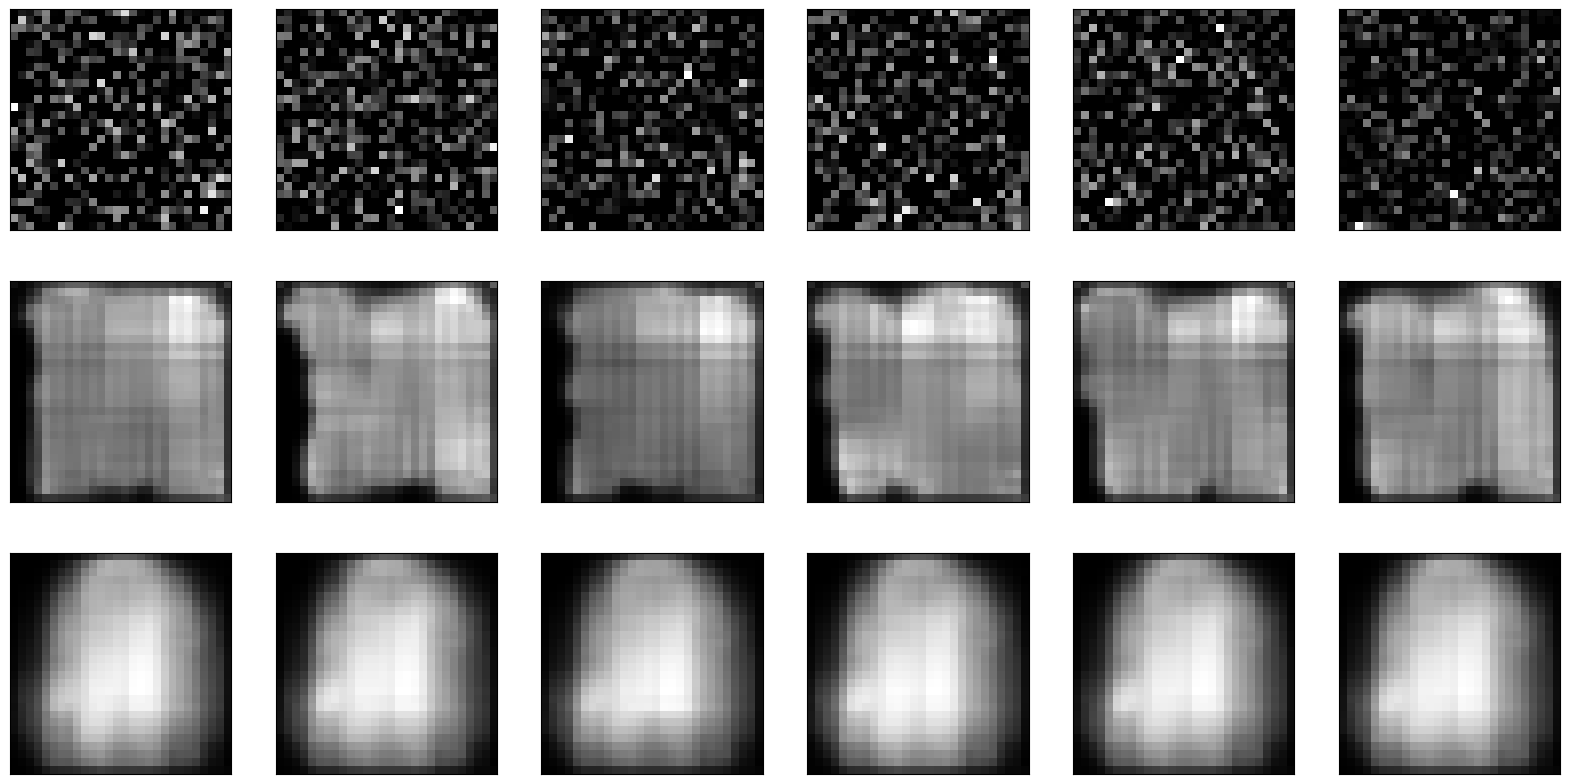

In [52]:
decoded_imgs = autoencoder.predict(x_test_noisy)

decoded_imgs_denoised = noisy_autoencoder.predict(x_test_noisy)

n = 6
plt.figure(figsize=(20, 10))
for i in range(1, n + 1):
    # Display original
    ax = plt.subplot(3, n, i)
    plt.imshow(x_test_noisy[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    if i==0:
        plt.ylabel("Original")
    else:
        ax.get_yaxis().set_visible(False)
        
    # Display reconstruction
    ax = plt.subplot(3, n, i + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    if i==0:
        plt.ylabel("Vanilla Autoencoder")
    else:
        ax.get_yaxis().set_visible(False)
     
    ax = plt.subplot(3, n, i + 2*n)
    plt.imshow(decoded_imgs_denoised[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    if i==0:
        plt.ylabel("Denoising Autoencoder")
    else:
        ax.get_yaxis().set_visible(False)
    
        
plt.show()

313/313 [==============================] - 0s 1ms/step

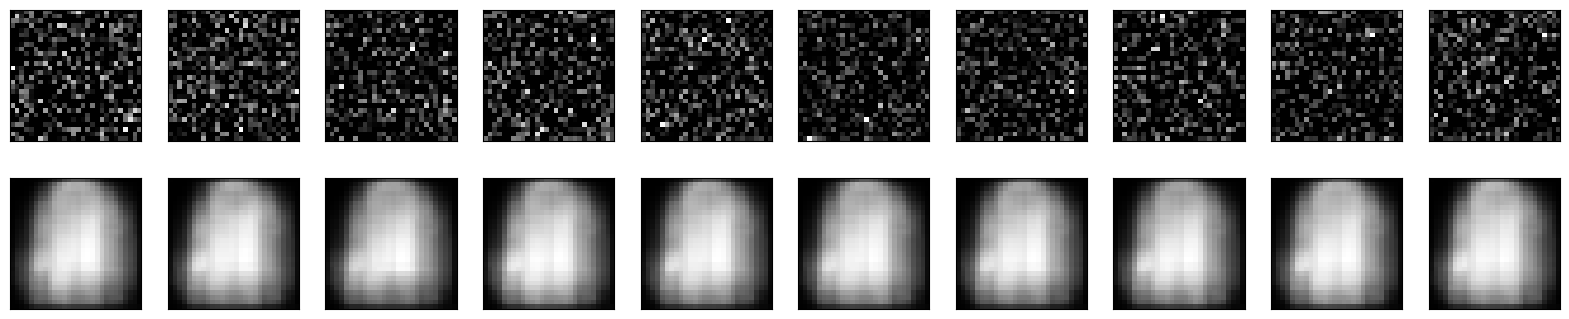

In [53]:
decoded_imgs = noisy_autoencoder.predict(x_test_noisy)

n = 10
plt.figure(figsize=(20, 4))
for i in range(1, n + 1):
    # Display original
    ax = plt.subplot(2, n, i)
    plt.imshow(x_test_noisy[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display reconstruction
    ax = plt.subplot(2, n, i + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()